In [318]:
%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt

from src.channel_blocks import ChannelBlocks
from src.channel_simulation import ChannelSimulator
from src.split_step_fourier import SplitStepFourier
from src.visualizer import Visualizer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Channel Simulation
here starts the actual channel simulator code.

In [319]:
ssf = SplitStepFourier(
    alpha=0,
    b2=-20e-27,
    gamma=0.003,
    t0=125e-12,
    last_step=1e-1,
    dt=1e-12*1e4,
    h=3
)
cs = ChannelSimulator(m_qam=16,
                      num_symbols=512,
                      normalization_factor=0.00001,
                      channel_func=ssf,
                      verbose=True)

cb = ChannelBlocks(cs.verbose)
np.set_printoptions(threshold=250)

number of iterations in split step algo: 26042


## 0) Generate message

In [320]:

cs.x[0] = cb.generate_message(cs.length_of_msg, cs.sps)


_______________________________________________
message before channel - len=2048
[[1 0 0 1]
 [1 0 0 0]
 [0 1 0 1]
 ...
 [1 0 1 1]
 [0 1 1 0]
 [0 0 1 0]]


## 1) Modulation


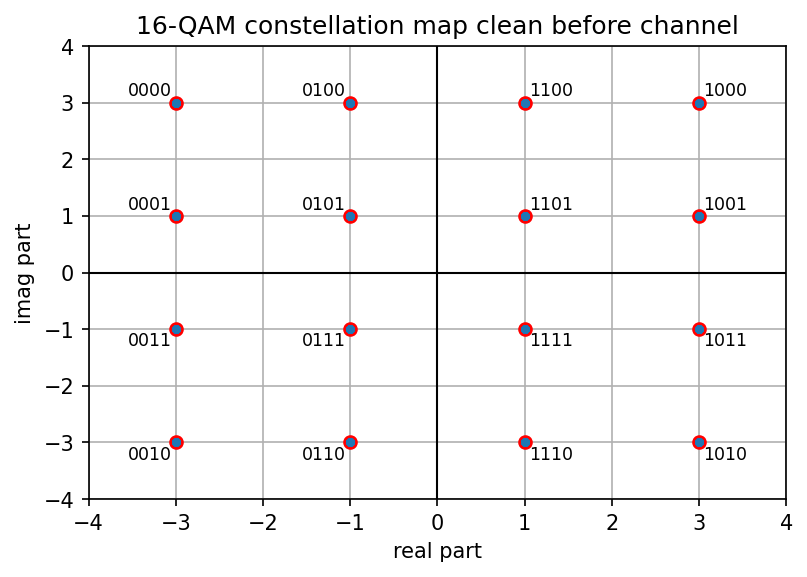

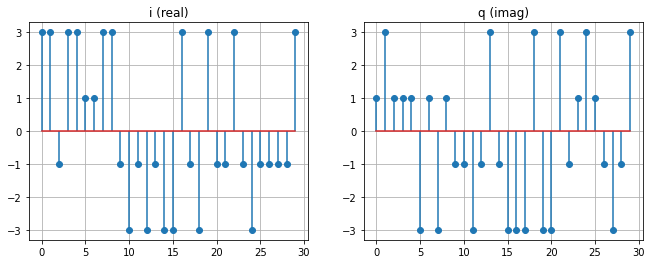

num of symbols = 512


In [321]:
cs.x[1], cs.modem = cb.modulate(cs.x[0], cs.m_qam)

### 1.1) Test demod

In [322]:
x0_reconst = cs.modem.demodulate(cs.x[1])
num_errors = (x0_reconst != cs.x[0]).sum()
if cs.verbose:
    Visualizer.print_bits(x0_reconst, cs.sps, 'test reconstructed msg')
    Visualizer.print_bits(cs.x[0], cs.sps, 'message before channel')
    print(f'ber = {num_errors / cs.length_of_msg} = {num_errors}/{cs.length_of_msg}')


_______________________________________________
test reconstructed msg - len=2048
[[1 0 0 1]
 [1 0 0 0]
 [0 1 0 1]
 ...
 [1 0 1 1]
 [0 1 1 0]
 [0 0 1 0]]

_______________________________________________
message before channel - len=2048
[[1 0 0 1]
 [1 0 0 0]
 [0 1 0 1]
 ...
 [1 0 1 1]
 [0 1 1 0]
 [0 0 1 0]]
ber = 0.0 = 0/2048


## 2) over sampling
over sample a vector by factor, using zero padding in between each sample

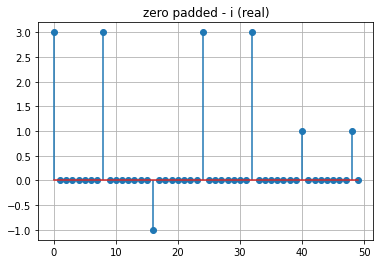

vec length = 4089, over_sampling period = 8


In [323]:
cs.x[2] = cb.over_sample(cs.x[1], cs.over_sampling)

## 3) Pulse Shaping
* convolve with filter: rrc
* fliter length is chosen such that x afterwards will be length power of two (closest above)

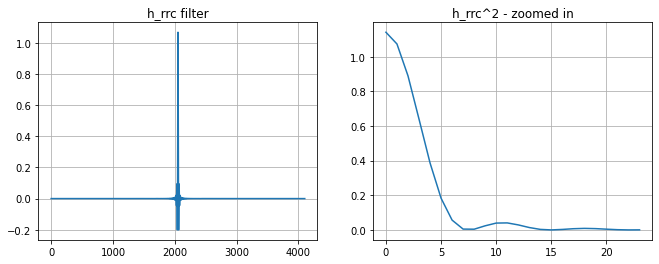

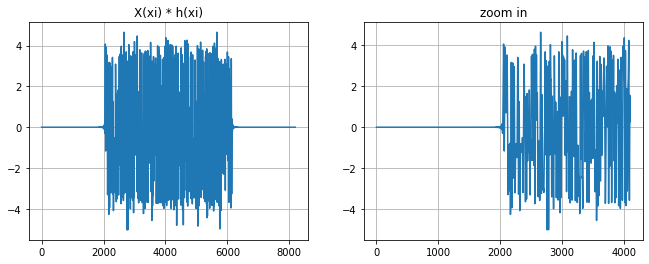

filter len = 4104, signal len = 8192


In [324]:
cs.x[3], cs.L_rrc, cs.h_rrc = cb.pulse_shape(cs.x[2], cs.roll_off,cs.over_sampling,cs.Ts)

### 3.1 Test: reconstruction
before we move on, lets try to restore this using match filter


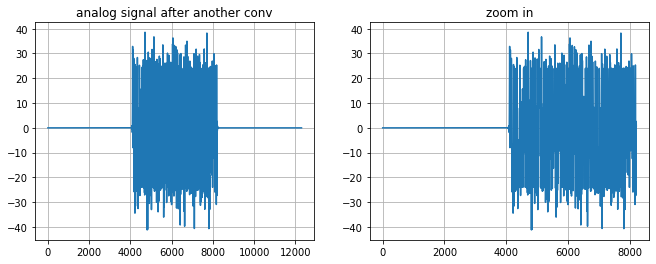

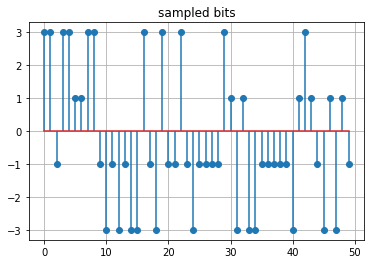

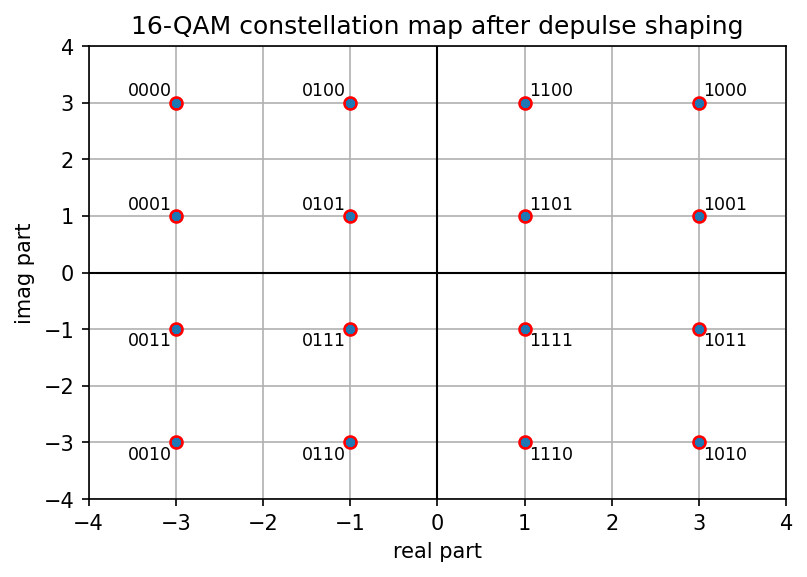

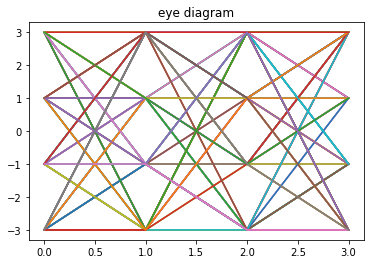

In [325]:
xx41 = np.convolve(cs.x[3], cs.h_rrc)

# sampling the analog vector into discrete bits
L_rrc = len(cs.h_rrc)
start = L_rrc
stop = - L_rrc + cs.over_sampling
step = cs.over_sampling
xx42 = xx41[start:stop:step] / cs.over_sampling

if cs.verbose:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))
    Visualizer.my_plot(np.real(xx41), name='analog signal after another conv', ax=ax1, hold=1)
    Visualizer.my_plot(np.real(xx41[:L_rrc * 2]), name='zoom in', ax=ax2)

    Visualizer.my_plot(np.real(xx42[0:50]), name='sampled bits', function='stem')

    Visualizer.plot_constellation_map_with_points(xx42, cs.m_qam, 'after depulse shaping')
    Visualizer.eye_diagram(xx42, sps=cs.sps)


## 4) Pre-Equalizer
*   normalize




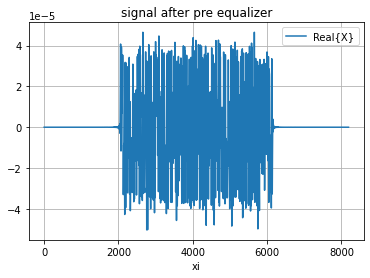

signal len = 8192


In [326]:
cs.x[4] = cb.pre_equalize(cs.x[3],cs.normalization_factor)

## 5) INFT

t  ∈ [-30.00:30.00]   ,	 N_time (=D) = 8192
xi ∈ [-214.39:214.44] ,	 N_xi   (=M) = 8192
BW = 214.44


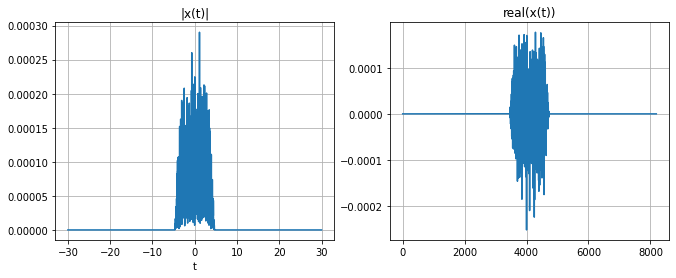

length of INFT(x) = 8192


In [327]:
cs.N_xi, cs.N_time, cs.tvec, cs.xivec, cs.BW = cb.gen_nft_params(cs.x[4],Tmax=cs.Tmax)
cs.x[5] = cb.inft(cs.x[4],cs.tvec,cs.xivec)

## 6) Channel 
  (split step fourier)

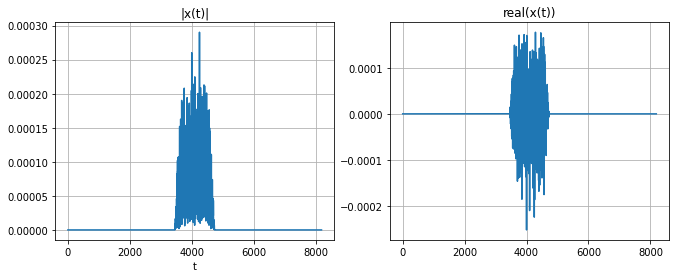

In [328]:
cs.x[6] = cb.channel(cs.x[5],cs.channel_func)

## 7) NFT

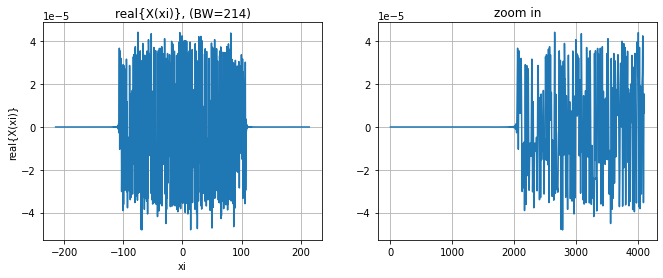

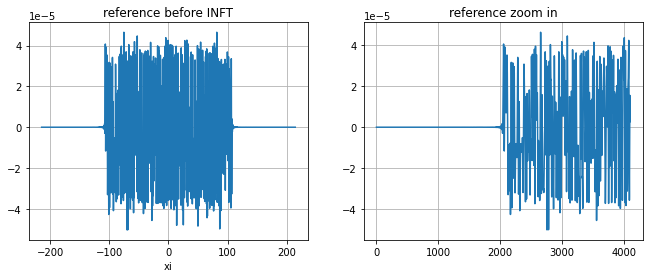

In [329]:
cs.x[7] = cb.nft(cs.x[6],cs.tvec,cs.xivec,cs.BW,cs.N_xi,cs.L_rrc,cs.x[4])

## 8) Equalizer


*   de-normalize
*   channel equalizer (nothing)



In [330]:
cs.x[8] = cb.equalizer(cs.x[7], cs.normalization_factor)

## 9) Match Filter
convolve again with the rrc filter and sample at the over sampling period

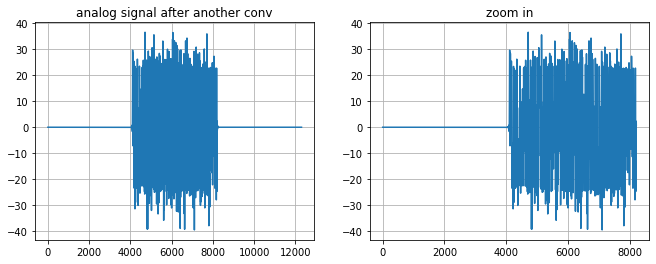

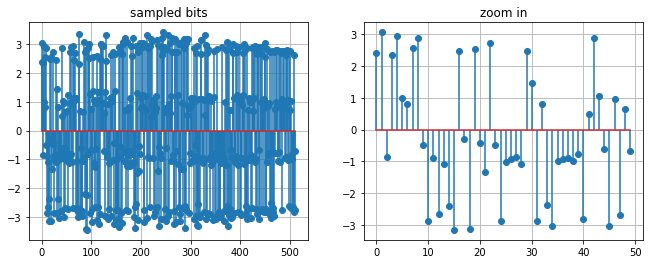

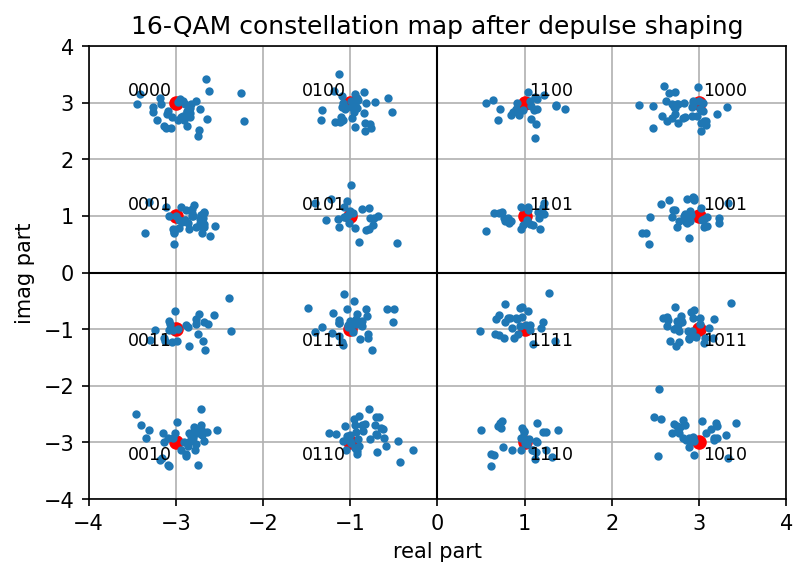

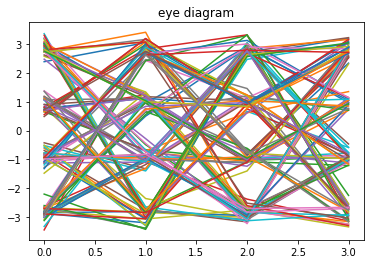

In [331]:
cs.x[9] = cb.match_filter(cs.x[8],cs.h_rrc,cs.L_rrc,cs.over_sampling,cs.m_qam,cs.sps)

## 10) Demodulation

In [332]:
cs.x[10] = cb.demodulate(cs.x[9],cs.modem, cs.length_of_msg)
ber, num_errors = cb.calc_ber(cs.x[0],cs.x[10],cs.length_of_msg,cs.sps)


_______________________________________________
message after channel - len=2048
[[1 0 0 1]
 [1 0 0 0]
 [0 1 0 1]
 ...
 [1 0 1 1]
 [0 1 1 0]
 [0 0 1 0]]
ber = 0.0 = 0/2048
